In [1]:
import pyspark.sql.functions as F
from pyspark.sql.types import *

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
findspark.find()

spark = SparkSession.builder.getOrCreate()
from pyspark.sql.types import *

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/05 13:29:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# check
spark

In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics

import matplotlib.pyplot as plt

# import the required functions
from pyspark.ml.feature import Binarizer, StringIndexer, VectorIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType

# import the required packages
import sparknlp
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF
from sparknlp.base import DocumentAssembler
from pyspark.ml.feature import StopWordsRemover, CountVectorizer

# import the required packages
from pyspark.ml.feature import Word2Vec

import demoji

from nltk.corpus import stopwords
STOPWORDS = stopwords.words("english")

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
import os

# 1. load data 

os.getcwd()

In [4]:
os.getcwd()

'/Users/echo/Desktop/BigData/Group_Assignment'

In [5]:
# import data 
final_df = spark.read.csv('./data/twitter_ks_basetable.csv',header=True).drop('_c0')

In [6]:
final_df.limit(5).toPandas()

,id,pos_sentiment_osm_sum,neg_sentiment_osm_sum,neg_sentiment_esm_sum,pos_sentiment_esm_sum,rt_avg_osm,rt_avg_esm,uf_avg_osm,uf_avg_esm,ufr_avg_osm,...,us_avg_osm,us_avg_esm,Tweet_media_type_photo_sum,label,goal,Category_project,pledged,backers_count,percentage_pledged,duration_30
0,1528387948,2.4475409836065576,0.6032786885245902,0.0,1.0,5.526197585587195,0.0,3563.0943577128814,412.0,982.1068795122508,...,8854.187024180192,823.0,1.0,1,8000.0,Comics,5515.29,74.0,0.68941125,0
1,2040864868,2.4475409836065576,0.6032786885245902,0.0,2.0,5.526197585587195,0.5,3563.0943577128814,1069.0,982.1068795122508,...,8854.187024180192,18111.0,0.0,1,38500.0,Games,4933.5,179.0,0.12814285714285714,1
2,1930851456,0.0,0.0,0.7494669509594882,2.4520255863539444,2.0,1.432957127002231,8.0,5754.908267090226,8.0,...,4.0,27513.677452778888,0.0,1,1800.0,Missing,58070.82196511628,270.35,0.0,0
3,55331564,2.4475409836065576,0.6032786885245902,0.0,1.0,5.526197585587195,0.0,3563.0943577128814,25807.5,982.1068795122508,...,8854.187024180192,17716.0,0.0,1,2500.0,Missing,58070.82196511628,270.35,0.0,0
4,770339794,2.4475409836065576,0.6032786885245902,0.0,0.0,5.526197585587195,0.0,3563.0943577128814,1.0,982.1068795122508,...,8854.187024180192,66.0,0.0,0,30000.0,Food,1.0,1.0,3.3333333333333335e-05,0


In [57]:
# check the statistical summury for all variables
final_df.describe().toPandas()

,summary,id,pos_sentiment_osm_sum,neg_sentiment_osm_sum,neg_sentiment_esm_sum,pos_sentiment_esm_sum,rt_avg_osm,rt_avg_esm,uf_avg_osm,uf_avg_esm,...,us_avg_osm,us_avg_esm,Tweet_media_type_photo_sum,label,goal,Category_project,pledged,backers_count,percentage_pledged,duration_30
0,count,6219,6219,6219,6219,6219,6219,6219,6219,6219,...,6219,6219,6219,6219,6219,6219,6219,6219,6219,6219
1,mean,1.0718713874942917E9,2.447540983606683,0.6032786885245119,0.7494669509594972,2.4520255863539178,5.52619758558692,1.4329571270022166,3563.094357712923,5754.908267090284,...,8854.187024181114,27513.67745277863,0.6930374658305194,0.874095513748191,66090.74047274482,None,58070.82196511561,270.3500000000191,0.7208247435778479,0.2630648014150185
2,stddev,6.22382428479419E8,11.023758974175104,0.9611282909731099,4.464843340312245,7.126144188269652,14.535981296125355,8.718361869534805,8605.244453118197,16259.409556983668,...,11137.344912770719,53493.115699582406,1.9725116656668373,0.33176836139081667,1090473.3132656927,None,229268.56649802497,450.94355481245,4.1091904916218756,0.4403327028216004
3,min,1000040509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0,1.0,Art,0.0,0.0,0.0,0
4,max,999282614,9.0,9.0,90.0,98.0,99.0,96.25,9998.0,999.9,...,9996.384615384615,9998.0,9.0,1,9999.0,Theater,996.0,99.0,93.074235,1


In [25]:
# check label :
final_df.groupBy('label').count().show()
# the data is unbalanced, we need to add weight to each label later

+-----+-----+
|label|count|
+-----+-----+
|    0|  783|
|    1| 5436|
+-----+-----+



In [62]:
final_df.dtypes

[('id', 'string'),
 ('pos_sentiment_osm_sum', 'string'),
 ('neg_sentiment_osm_sum', 'string'),
 ('neg_sentiment_esm_sum', 'string'),
 ('pos_sentiment_esm_sum', 'string'),
 ('rt_avg_osm', 'string'),
 ('rt_avg_esm', 'string'),
 ('uf_avg_osm', 'string'),
 ('uf_avg_esm', 'string'),
 ('ufr_avg_osm', 'string'),
 ('ufr_avg_esm', 'string'),
 ('ufav_avg_osm', 'string'),
 ('ufav_avg_esm', 'string'),
 ('us_avg_osm', 'string'),
 ('us_avg_esm', 'string'),
 ('Tweet_media_type_photo_sum', 'string'),
 ('label', 'string'),
 ('goal', 'string'),
 ('Category_project', 'string'),
 ('pledged', 'string'),
 ('backers_count', 'string'),
 ('percentage_pledged', 'string'),
 ('duration_30', 'string')]

In [ ]:
# we need to convert those type to numerical:
final_df.withColumns


In [68]:
final_df.limit(5).toPandas()

,id,pos_sentiment_osm_sum,neg_sentiment_osm_sum,neg_sentiment_esm_sum,pos_sentiment_esm_sum,rt_avg_osm,rt_avg_esm,uf_avg_osm,uf_avg_esm,ufr_avg_osm,...,us_avg_osm,us_avg_esm,Tweet_media_type_photo_sum,label,goal,Category_project,pledged,backers_count,percentage_pledged,duration_30
0,1528387948,2.4475409836065576,0.6032786885245902,0.0,1.0,5.526197585587195,0.0,3563.0943577128814,412.0,982.1068795122508,...,8854.187024180192,823.0,1.0,1,8000.0,Comics,5515.29,74.0,0.68941125,0
1,2040864868,2.4475409836065576,0.6032786885245902,0.0,2.0,5.526197585587195,0.5,3563.0943577128814,1069.0,982.1068795122508,...,8854.187024180192,18111.0,0.0,1,38500.0,Games,4933.5,179.0,0.12814285714285714,1
2,1930851456,0.0,0.0,0.7494669509594882,2.4520255863539444,2.0,1.432957127002231,8.0,5754.908267090226,8.0,...,4.0,27513.677452778888,0.0,1,1800.0,Missing,58070.82196511628,270.35,0.0,0
3,55331564,2.4475409836065576,0.6032786885245902,0.0,1.0,5.526197585587195,0.0,3563.0943577128814,25807.5,982.1068795122508,...,8854.187024180192,17716.0,0.0,1,2500.0,Missing,58070.82196511628,270.35,0.0,0
4,770339794,2.4475409836065576,0.6032786885245902,0.0,0.0,5.526197585587195,0.0,3563.0943577128814,1.0,982.1068795122508,...,8854.187024180192,66.0,0.0,0,30000.0,Food,1.0,1.0,3.3333333333333335e-05,0


In [7]:
for col in final_df.columns:
    if col=='label' or col=='duration_30':
        final_df=final_df.withColumn(col,F.col(col).cast('Integer'))
    elif col=='Category_project':
        final_df=final_df.withColumn(col,F.col(col).cast('String'))
    else:
        final_df=final_df.withColumn(col,F.col(col).cast(DoubleType()))
                
print(final_df.dtypes)

[('id', 'double'), ('pos_sentiment_osm_sum', 'double'), ('neg_sentiment_osm_sum', 'double'), ('neg_sentiment_esm_sum', 'double'), ('pos_sentiment_esm_sum', 'double'), ('rt_avg_osm', 'double'), ('rt_avg_esm', 'double'), ('uf_avg_osm', 'double'), ('uf_avg_esm', 'double'), ('ufr_avg_osm', 'double'), ('ufr_avg_esm', 'double'), ('ufav_avg_osm', 'double'), ('ufav_avg_esm', 'double'), ('us_avg_osm', 'double'), ('us_avg_esm', 'double'), ('Tweet_media_type_photo_sum', 'double'), ('label', 'int'), ('goal', 'double'), ('Category_project', 'string'), ('pledged', 'double'), ('backers_count', 'double'), ('percentage_pledged', 'double'), ('duration_30', 'int')]


# 1. Feature engineering


1, spilt data into train & val & test ( 0.6 : 0.2 : 0.2)  

2, handle unbalanced data : add weight to two classes       

3, for some numerical variables: standard scaler (except duration )

In [8]:
# split data into train & test ( 0.6 : 0.4) 
train, val, test = final_df.drop('id').randomSplit([0.6, 0.2, 0.2])

In [92]:
train.limit(5).toPandas()

,pos_sentiment_osm_sum,neg_sentiment_osm_sum,neg_sentiment_esm_sum,pos_sentiment_esm_sum,rt_avg_osm,rt_avg_esm,uf_avg_osm,uf_avg_esm,ufr_avg_osm,ufr_avg_esm,...,us_avg_osm,us_avg_esm,Tweet_media_type_photo_sum,label,goal,Category_project,pledged,backers_count,percentage_pledged,duration_30
0,0.0,0.0,0.0,0.0,0.0,0.0,155.0,1719.0,120.0,198.0,...,106.0,3937.0,0.0,1,67755.0,Missing,58070.821965,270.35,0.0000,1
1,0.0,0.0,0.0,0.0,0.0,0.0,255.0,1116.0,388.0,251.0,...,751.0,30219.0,0.0,0,20000.0,Missing,58070.821965,270.35,0.0000,0
2,0.0,0.0,0.0,0.0,0.0,0.0,406.0,284.0,121.0,1820.0,...,3320.0,31534.0,0.0,1,300.0,Missing,58070.821965,270.35,0.0000,0
3,0.0,0.0,0.0,0.0,0.0,0.0,3399.0,1756.5,38.0,2539.5,...,2625.0,15536.5,0.0,1,13000.0,Missing,58070.821965,270.35,0.0000,0
4,0.0,0.0,0.0,0.0,0.0,1.5,24.0,939.5,44.0,1050.5,...,5.0,10210.0,0.0,1,10000.0,Journalism,1446.000000,23.00,0.1446,0


In [9]:
# inspect proportion of label
train.groupBy("label").count().withColumn("percentage", F.col("count") / train.count()).show()

+-----+-----+-------------------+
|label|count|         percentage|
+-----+-----+-------------------+
|    1| 3289| 0.8728768577494692|
|    0|  479|0.12712314225053079|
+-----+-----+-------------------+



In [10]:
# data imbalance: 
weight_1 = (468 + 3242) / (3242 * 2)
weight_0 = (468 + 3242) / (468 * 2)

In [10]:
# check
print(weight_1)
print(weight_0)

0.5721776681061074
3.963675213675214


In [11]:
# add class weights column
train = train.withColumn("weight", F.when(F.col("label") == 1, weight_1).otherwise(weight_0))
val = val.withColumn("weight", F.when(F.col("label") == 1, weight_1).otherwise(weight_0))

## numerical variables:

assemble numerical columns and them scaler 

In [12]:
# required package
from pyspark.ml.feature import StandardScaler, VectorAssembler

In [13]:
# get numerical variables:
all_num_col =[item[0] for item in train.dtypes if item[1]!='string']
all_num_col.remove('duration_30')
all_num_col.remove('label')
all_num_col.remove('weight')

In [131]:
all_num_col 

['pos_sentiment_osm_sum',
 'neg_sentiment_osm_sum',
 'neg_sentiment_esm_sum',
 'pos_sentiment_esm_sum',
 'rt_avg_osm',
 'rt_avg_esm',
 'uf_avg_osm',
 'uf_avg_esm',
 'ufr_avg_osm',
 'ufr_avg_esm',
 'ufav_avg_osm',
 'ufav_avg_esm',
 'us_avg_osm',
 'us_avg_esm',
 'Tweet_media_type_photo_sum',
 'goal',
 'pledged',
 'backers_count',
 'percentage_pledged']

In [14]:
# get ks_numerical columns and twitter_numerical columns seperately

ks_num_col = ['goal','pledged','backers_count','percentage_pledged']
twitter_num_col = all_num_col[:-4]

In [15]:
# VectorAssembler :
VAnum_all = VectorAssembler(inputCols=all_num_col,outputCol='numFeatures')
VAnum_ks = VectorAssembler(inputCols=ks_num_col,outputCol='numFeatures')
VAnum_twitter = VectorAssembler(inputCols=twitter_num_col,outputCol='numFeatures')

### Intialize scaler for numeric variables

SS = StandardScaler(inputCol = 'numFeatures', outputCol = 'scaledNumFeatures', withStd = True, withMean = False)

### Put categorical features to index


In [16]:
# define vector assembler for categorical features add imputed ones and indexed ones
catColumns = ['Category_project'] #'staff_pick',

catColumns_idx = [var + "_idx" for var in catColumns]

# define vector indexer
VI = StringIndexer(inputCols = catColumns, outputCols = catColumns_idx)

# assemble categorical features
VAcat = VectorAssembler(inputCols = catColumns_idx, outputCol = 'cat_features_idx')

## combien all features 

In [17]:
# Vector assembler relevant columns into one 
VA_all_features = VectorAssembler(inputCols = ['scaledNumFeatures', 'cat_features_idx','duration_30'], outputCol = 'features') 
# for twitter variables: no need to assemble 
VA_all_twitter = VectorAssembler(inputCols = ['scaledNumFeatures'], outputCol = 'features') 
VA_all_ks =  VectorAssembler(inputCols = ['scaledNumFeatures', 'cat_features_idx','duration_30'], outputCol = 'features') 


## Feature selection 

let's try to get the top 12 features according to a chi-squared test ( actually we already examined the importance of variables in previous regression analysis)

however we could still make 4 set of variables: 

- one with all variables( twitter + ks )
- one with top 12 variables 
- one with only twitter variables
- one with only ks variables



ChiSqSelector stands for Chi-Squared feature selection. It operates on labeled data with categorical features. ChiSqSelector uses the Chi-Squared test of independence to decide which features to choose. It supports five selection methods: numTopFeatures, percentile, fpr, fdr, fwe:

numTopFeatures chooses a fixed number of top features according to a chi-squared test. This is akin to yielding the features with the most predictive power.
percentile is similar to numTopFeatures but chooses a fraction of all features instead of a fixed number.
fpr chooses all features whose p-values are below a threshold, thus controlling the false positive rate of selection.
fdr uses the Benjamini-Hochberg procedure to choose all features whose false discovery rate is below a threshold.
fwe chooses all features whose p-values are below a threshold. The threshold is scaled by 1/numFeatures, thus controlling the family-wise error rate of selection. By default, the selection method is numTopFeatures, with the default number of top features set to 50. The user can choose a selection method using setSelectorType.

In [18]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

In [19]:
selector = ChiSqSelector(numTopFeatures=12, featuresCol="features",
                         outputCol="topFeatures", labelCol="label")

In [ ]:
# define pipeline stages
stages_selected = [VAnum,SS,VI,VAcat,VA_all_features,selector]

In [ ]:
# check the top 12 variables selected 
pipeline_sector = Pipeline(stages= stages_selected).fit(train)
result = pipeline_sector.transform(train)

In [116]:
print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
result.limit(5).toPandas()

ChiSqSelector output with top 12 features selected


,pos_sentiment_osm_sum,neg_sentiment_osm_sum,neg_sentiment_esm_sum,pos_sentiment_esm_sum,rt_avg_osm,rt_avg_esm,uf_avg_osm,uf_avg_esm,ufr_avg_osm,ufr_avg_esm,...,backers_count,percentage_pledged,duration_30,weight,numFeatures,scaledNumFeatures,Category_project_idx,cat_features_idx,features,topFeatures
0,0.0,0.0,0.0,0.0,0.0,0.0,155.0,1719.0,120.0,198.0,...,270.35,0.0000,1,0.572178,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 155.0, 1719.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0229453562115...",0.0,[0.0],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0229453562115...","(0.0, 0.0, 0.0, 0.0, 0.02565110886748738, 0.0,..."
1,0.0,0.0,0.0,0.0,0.0,0.0,255.0,1116.0,388.0,251.0,...,270.35,0.0000,0,3.963675,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 255.0, 1116.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0377488118318...",0.0,[0.0],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0377488118318...","(0.0, 0.0, 0.0, 0.0, 0.032517314776461276, 0.0..."
2,0.0,0.0,0.0,0.0,0.0,0.0,406.0,284.0,121.0,1820.0,...,270.35,0.0000,0,0.572178,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 406.0, 284.0, 1...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0601020298185...",0.0,[0.0],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0601020298185...","(0.0, 0.0, 0.0, 0.0, 0.23578291989306582, 0.0,..."
3,0.0,0.0,0.0,0.0,0.0,0.0,3399.0,1756.5,38.0,2539.5,...,270.35,0.0000,0,0.572178,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3399.0, 1756.5,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5031694565349...",0.0,[0.0],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5031694565349...","(0.0, 0.0, 0.0, 0.0, 0.32899490388375857, 0.0,..."
4,0.0,0.0,0.0,0.0,0.0,1.5,24.0,939.5,44.0,1050.5,...,23.00,0.1446,0,0.572178,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 24.0, 939.5, 44...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.13995038346241434,...",13.0,[13.0],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.13995038346241434,...","[0.0, 0.0, 0.0, 0.0, 0.13609338315805805, 0.0,..."


## Combine stages

In [20]:
stages_all_features = [VAnum_all,SS,VI,VAcat,VA_all_features]
# stage_selected : stages with feature selection 
stages_twitter_features = [VAnum_twitter,SS,VA_all_twitter]
stages_ks_features = [VAnum_ks,SS,VI,VAcat,VA_all_ks]

# Modeling

In [21]:
# import model
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier

In [22]:
# define models : we will use random forest, logistic regression and XGboost
RF = RandomForestClassifier(labelCol='label',featuresCol='features',weightCol='weight',numTrees = 500)
LR = LogisticRegression(featuresCol="features", labelCol="label",weightCol='weight')


### Cross validation to tune the parameters of XGboost


but It lower the running speed so we decided to delete this step, but the full code is below 

In [23]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

In [24]:
# parameter validation for XGboost 
XG = GBTClassifier(featuresCol="features", labelCol="label",weightCol='weight',maxDepth=5,maxIter=50)

paramGrid = ParamGridBuilder()\
            .addGrid(XG.maxDepth, [3,5]) \
            .addGrid(XG.maxIter, [10,50]) \
            .build()
            
            
CV = CrossValidator(estimator=XG,estimatorParamMaps=paramGrid,\
                          evaluator=BinaryClassificationEvaluator(),\
                          numFolds=2)

In [25]:
# define pipeline for random forest

RF_pipeline_all = Pipeline(stages=stages_all_features+[RF]).fit(train)
#RF_pipeline_selected = Pipeline(stages=stages_selected+[RF]).fit(train)
RF_pipeline_twitter = Pipeline(stages=stages_twitter_features+[RF]).fit(train)
RF_pipeline_ks = Pipeline(stages=stages_ks_features+[RF]).fit(train)



22/09/05 14:05:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


22/09/05 14:05:24 WARN DAGScheduler: Broadcasting large task binary with size 1174.2 KiB


22/09/05 14:05:26 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/09/05 14:05:36 WARN DAGScheduler: Broadcasting large task binary with size 1033.0 KiB


22/09/05 14:05:39 WARN DAGScheduler: Broadcasting large task binary with size 1786.1 KiB


22/09/05 14:05:47 WARN DAGScheduler: Broadcasting large task binary with size 1164.7 KiB


22/09/05 14:05:49 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


In [26]:
# define pipeline for LR
LR_pipeline_all = Pipeline(stages=stages_all_features+[LR]).fit(train)
#LR_pipeline_selected = Pipeline(stages=stages_selected+[LR]).fit(train)
LR_pipeline_twitter = Pipeline(stages=stages_twitter_features+[LR]).fit(train)
LR_pipeline_ks = Pipeline(stages=stages_ks_features+[LR]).fit(train)


22/09/05 14:23:13 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
22/09/05 14:23:13 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/09/05 14:23:13 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [27]:
# define pipeline for XGboost
XG_pipeline_all = Pipeline(stages=stages_all_features+[XG]).fit(train)
#XG_pipeline_selected = Pipeline(stages=stages_selected+[XG]).fit(train)
XG_pipeline_twitter = Pipeline(stages=stages_twitter_features+[XG]).fit(train)
XG_pipeline_ks = Pipeline(stages=stages_ks_features+[XG]).fit(train)




In [28]:
# rondom forest : get predictions on validation set
model_rf1_preds = RF_pipeline_all.transform(val)
#model_rf2_preds = RF_pipeline_selected.transform(val)
model_rf3_preds = RF_pipeline_twitter.transform(val)
model_rf4_preds = RF_pipeline_ks.transform(val)


In [29]:
# Logistic regression: 
model_lg1_preds = LR_pipeline_all.transform(val)
#model_lg2_preds = LR_pipeline_selected.transform(val)
model_lg3_preds = LR_pipeline_twitter.transform(val)
model_lg4_preds = LR_pipeline_ks.transform(val)

In [30]:
# xgboost
model_xg1_preds = XG_pipeline_all.transform(val)
#model_xg2_preds = XG_pipeline_selected.transform(val)
model_xg3_preds = XG_pipeline_twitter.transform(val)
model_xg4_preds = XG_pipeline_ks.transform(val)

# Evaluation

In [31]:
# import evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator



In [32]:
# define the evaluator:ROC 
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label", metricName="areaUnderROC")
# evaluate random forest 
model_1_auc = evaluator.evaluate(model_rf1_preds)
#model_2_auc = evaluator.evaluate(model_rf2_preds)
model_3_auc = evaluator.evaluate(model_rf3_preds)
model_4_auc = evaluator.evaluate(model_rf4_preds)



22/09/05 15:09:16 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/09/05 15:09:17 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/09/05 15:09:18 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [33]:
# print the auc random forest
print(model_1_auc)
#print(model_2_auc)
print(model_3_auc)
print(model_4_auc)

0.8476429159302183
0.7323859573377227
0.8098378239810029


In [34]:
# evaluate logistic regression
model_5_auc = evaluator.evaluate(model_lg1_preds)
#model_6_auc = evaluator.evaluate(model_lg2_preds)
model_7_auc = evaluator.evaluate(model_lg3_preds)
model_8_auc = evaluator.evaluate(model_lg4_preds)


# print the auc
print(model_5_auc)
#print(model_6_auc)
print(model_7_auc)
print(model_8_auc)

0.8104550912746068
0.6890018484288355
0.795789090222216


In [35]:
# evaluate RF
model_9_auc = evaluator.evaluate(model_xg1_preds)
#model_10_auc = evaluator.evaluate(model_xg2_preds)
model_11_auc = evaluator.evaluate(model_xg3_preds)
model_12_auc = evaluator.evaluate(model_xg4_preds)


# print the auc
print(model_9_auc)
#print(model_10_auc)
print(model_11_auc)
print(model_12_auc)

0.8199603329870344
0.7004162337925173
0.7774667080426894


# Comparaison of theses three models


In [36]:
# bar chart 
dict_ = {'Random_Forest':[model_1_auc,model_3_auc,model_4_auc],
         'Logistic_Regression':[model_5_auc,model_7_auc,model_8_auc],
         'XGBoost':[model_9_auc,model_11_auc,model_12_auc],
          'data_type':['all','tweet','ks']}
pd = pd.DataFrame(dict_)

In [37]:
list_dict=['Random_Forest','Logistic_Regression','XGBoost']


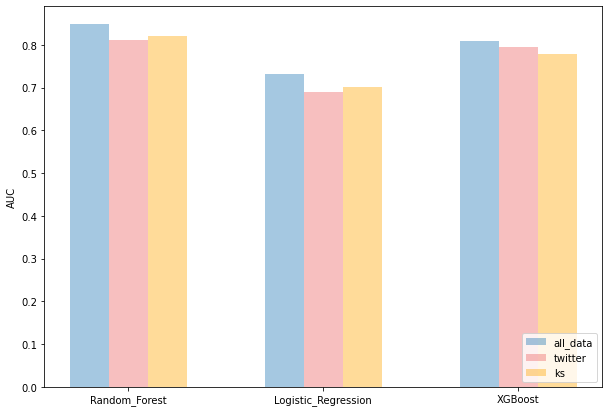

In [39]:
plt.figure(figsize=(10,7))

# 对应的y轴
plt.bar(np.arange(3),dict_['Random_Forest'],alpha=0.4,width=0.2,label='all_data')
plt.bar(np.arange(3)+0.2,dict_['Logistic_Regression'],color='lightcoral',alpha=0.5,width=0.2,label='twitter')
plt.bar(np.arange(3)+0.4,dict_['XGBoost'],color='orange',width=0.2,alpha=0.4,label='ks')
plt.xticks(np.arange(3)+0.2,list_dict)
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.show()

 1.we found that model with all data is more performant than other subset. 

In [40]:
from sklearn.metrics import roc_curve
from pyspark.ml.functions import vector_to_array


In [41]:
y_score = model_xg1_preds.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_true = model_xg1_preds.select("label").rdd.keys().collect()
fpr, tpr, thresholds = roc_curve(y_true, y_score)

22/09/05 15:10:43 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


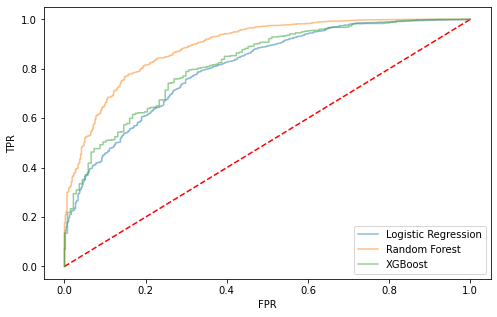

In [42]:
plt.figure(figsize=(8,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(LR_pipeline_all.stages[-1].summary.roc.select('FPR').collect(),
         LR_pipeline_all.stages[-1].summary.roc.select('TPR').collect(),alpha=0.5,label='Logistic Regression')

plt.plot(RF_pipeline_all.stages[-1].summary.roc.select('FPR').collect(),
         RF_pipeline_all.stages[-1].summary.roc.select('TPR').collect(),alpha=0.5,label='Random Forest')

plt.plot(fpr,tpr,alpha=0.5,label='XGBoost')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()

# Final prediction 

As we conducted modeling for 3 different algorithm, we found Random Forest outperform than other algorithms 

In [43]:
big_train = train.unionAll(val)

# set pipeline 
RF_pipeline_all = Pipeline(stages=stages_all_features+[RF]).fit(big_train)
#RF_pipeline_selected = Pipeline(stages=stages_selected+[RF]).fit(big_train)
RF_pipeline_twitter = Pipeline(stages=stages_twitter_features+[RF]).fit(big_train)
RF_pipeline_ks = Pipeline(stages=stages_ks_features+[RF]).fit(big_train)



# rondom forest : get predictions on testidation set
model_rf1_preds = RF_pipeline_all.transform(test)
#model_rf2_preds = RF_pipeline_selected.transform(test)
model_rf3_preds = RF_pipeline_twitter.transform(test)
model_rf4_preds = RF_pipeline_ks.transform(test)

22/09/05 15:10:58 WARN DAGScheduler: Broadcasting large task binary with size 1227.5 KiB


22/09/05 15:11:01 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/09/05 15:11:14 WARN DAGScheduler: Broadcasting large task binary with size 1095.9 KiB


22/09/05 15:11:15 WARN DAGScheduler: Broadcasting large task binary with size 1879.2 KiB


22/09/05 15:11:23 WARN DAGScheduler: Broadcasting large task binary with size 1207.0 KiB


22/09/05 15:11:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


# Evaluation of final model

In [45]:
# etestuate random forest evaluator.evaluate
model_1_auc = evaluator.evaluate(model_rf1_preds)
#model_2_auc = evaluator.evaluate(model_rf2_preds)
model_3_auc = evaluator.evaluate(model_rf3_preds)
model_4_auc = evaluator.evaluate(model_rf4_preds)


# print the auc
print(model_1_auc)
#print(model_2_auc)
print(model_3_auc)
print(model_4_auc)


22/09/05 15:12:20 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/09/05 15:12:20 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/09/05 15:12:21 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
0.8385848022265321
0.7353349638750671
0.8039245452756462


22/09/05 15:12:28 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/09/05 15:12:28 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/09/05 15:12:29 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


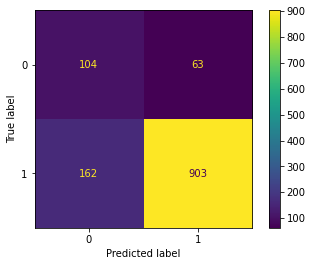

In [46]:
# import confusion matrix and get confusion matrix for all variables 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# get predictions and labels
preds_and_labels = model_rf1_preds.select(['prediction','label']) \
                                  .withColumn('label', F.col('label').cast(FloatType())) \
                                  .orderBy('prediction') \
                                  .toPandas()

# get confusion matrix
cm = confusion_matrix(preds_and_labels["label"], preds_and_labels["prediction"], labels=[0, 1])
# get confusion matrix figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
# plot figure
disp.plot()
plt.show()

# Interpretation of outcome 


1. feature importance
2. AUC 

In [198]:
RF_pipeline_all.stages
# you can find all stages : sclaler , indexer ...


[VectorAssembler_d45b65463688,
 StandardScalerModel: uid=StandardScaler_6773088b2217, numFeatures=19, withMean=false, withStd=true,
 StringIndexerModel: uid=StringIndexer_7bf9e5523345, handleInvalid=error, numInputCols=1, numOutputCols=1,
 VectorAssembler_88ce207c8375,
 VectorAssembler_6a07530968de,
 RandomForestClassificationModel: uid=RandomForestClassifier_41ba45a73fff, numTrees=500, numClasses=2, numFeatures=21]

In [48]:
all_variables = big_train.columns

all_variables.remove('weight')


In [49]:
feature_scores = RF_pipeline_all.stages[-1].featureImportances
# get the feature names
feature_names = all_num_col + catColumns + ['duration_30']
# zip
feature_names_scores = zip(feature_names, feature_scores)
# sort
feature_names_scores_sorted = sorted(feature_names_scores, key=lambda x: x[1], reverse=False)
# get feature names
feature_names_sorted = [obs[0] for obs in feature_names_scores_sorted]
# get feature scores
feature_scores_sorted = [obs[1] for obs in feature_names_scores_sorted]

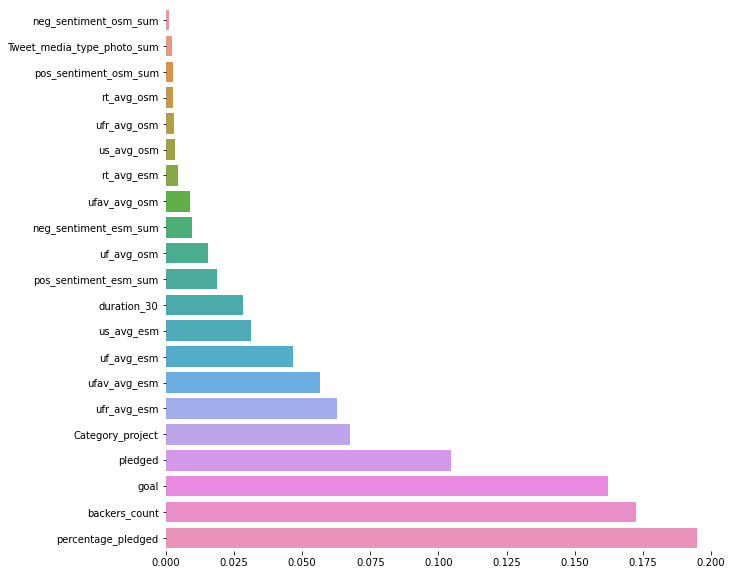

In [50]:
plt.figure(figsize=(10, 10))
sns.barplot(y=feature_names_sorted, x=feature_scores_sorted)
sns.despine(left = True, bottom = True)
plt.show()